# Multi-objective Robust Optimization (MORO)


This exercise demostrates the application of MORO on the lake model. In contrast to the exercises in previous weeks, we will be using a slightly more sophisticated version of the problem. For details see the MORDM assignment for this week.

## Setup MORO

Many objective robust optimization aims at finding decisions that are robust with respect to the various deeply uncertain factors. For this, MORO evalues each candidate decision over a set of scenarios. For each outcome of interest, the robusntess over this set is calculated. A Many-objective Genetic Algorithm is used to maximize the robustness. 

For this assignment, we will be using a domain criterion as our robustness metric. The table below lists the rules that you should use for each outcome of interest.

|Outcome of interest| threhsold  |
|-------------------|------------|
| Maximum pollution | $\leq$ 0.75|
| Inertia           | $\geq$ 0.6 |
| Reliability       | $\geq$ 0.99|   
| Utility           | $\geq$ 0.75|

** Implement a function for each outcome that takes a numpy array with results for the outcome of interest, and returns the robustness score **

In [57]:
def robustness(data, mean=True):
    """
    this function:
    1. takes results of EMA experiments
    2. returns robustness score of each policy in a pd.Series form
    """
    results = data
    
    # convert
    def make_df(results):
        experiments, outcomes = results

        # DATA of INPUTS
        experiments = np.lib.recfunctions.drop_fields(base = experiments, drop_names = [str(i) for i in range(100)])
        experiments = pd.DataFrame(experiments)

        n_scenarios = experiments["scenario_id"].nunique()
        n_policies = experiments["policy"].nunique()

        # POLICIES (STRING representation into DICTIONARY)
        policies = experiments["policy"].unique()
        func = lambda x: ast.literal_eval(x)
        vfunc = np.vectorize(func)
        policies = vfunc(policies)
        policies = pd.DataFrame(policies)

        experiments["policy"] = np.repeat(range(n_policies), n_scenarios)

        # DATA of OUTPUTS
        outcomes = pd.DataFrame(outcomes)
        outcomes["policy"] = experiments["policy"].values
        outcomes.set_index("policy", inplace = True)

        return experiments, outcomes, policies
    
    def evaluate(outcome, th_inertia = 0.6, th_max_P = 0.75, th_reliability = 0.99, th_utility = 0.75):
        """
        evaluate a single scenario
        l is a numpy array of evaluating whether 4 outcomes meet the respective criterion or not 
        """
        inertia, max_P, reliability, utility = outcome
        i_score = inertia / th_inertia
        m_score = th_max_P / max_P
        r_score = reliability / th_reliability
        u_score = utility / th_utility
        l = np.array([i_score, m_score, r_score, u_score])

        return l
    
    outcomes = make_df(results)[1]
    
    if mean:
        robustness_score = outcomes.apply(lambda x: evaluate(x), axis = 1).groupby("policy").mean()
    else:
        robustness_score = outcomes.apply(lambda x: evaluate(x), axis = 1)

    return robustness_score

** Generate 4 random release policies, and evaluate them over 500 scenarios. Sample the scenarios using Monte Carlo sampling. Next evaulate your robustness function for 1, 2, 3, ... 500 scenarios for each outcome and visualize this.
What can you tell about the convergernce of the robusntess metric as a function of the number of scenarios?**

In [2]:
from lake import *

In [3]:
import ast
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (perform_experiments, Model, RealParameter, ScalarOutcome,
                           Constant, ema_logging, MultiprocessingEvaluator)
from ema_workbench.em_framework.evaluators import MC

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Anaconda3\envs\py36_32\lib\site-packages\ema_workbench\em_framework\optimization.py:29: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


<Logger EMA (DEBUG)>

In [4]:
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100

lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

lake_model.outcomes = [ScalarOutcome('max_P',),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in range(lake_model.time_horizon)]

In [5]:
n_scenarios = 500
n_policies = 4

with MultiprocessingEvaluator(lake_model) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, n_policies, levers_sampling=MC)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


#### Robustness Score of Each Policy (mean)

In [58]:
robustness(results).T

policy,0,1,2,3
inertia,0.639731,0.521886,0.538721,0.538721
max_P,0.740931,0.865525,0.846333,0.882656
reliability,0.415033,0.475650,0.447056,0.443919
utility,0.790011,0.703908,0.694020,0.759074


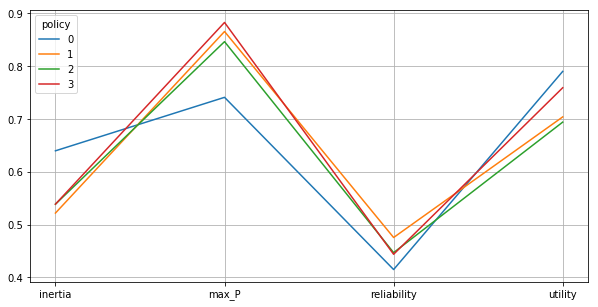

In [59]:
fig, ax = plt.subplots(figsize = (10,5))
robustness(results).T.plot(ax = ax)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(robustness(results).T.index)
ax.grid()

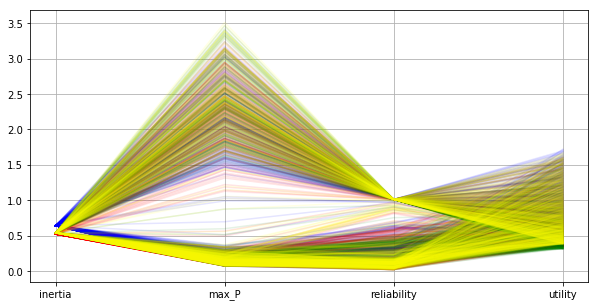

In [74]:
df = robustness(results, mean=False)
outcomes = df.columns
colors = ["blue", "red", "green", "yellow"]

fig, ax = plt.subplots(figsize = (10,5))
for i in df.index.unique():
    df_policy = df.loc[i]
    for row in df_policy.reset_index().index:
        df_policy.iloc[row].plot(ax = ax, color = colors[i], alpha = 0.1)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(df.columns)
ax.grid()

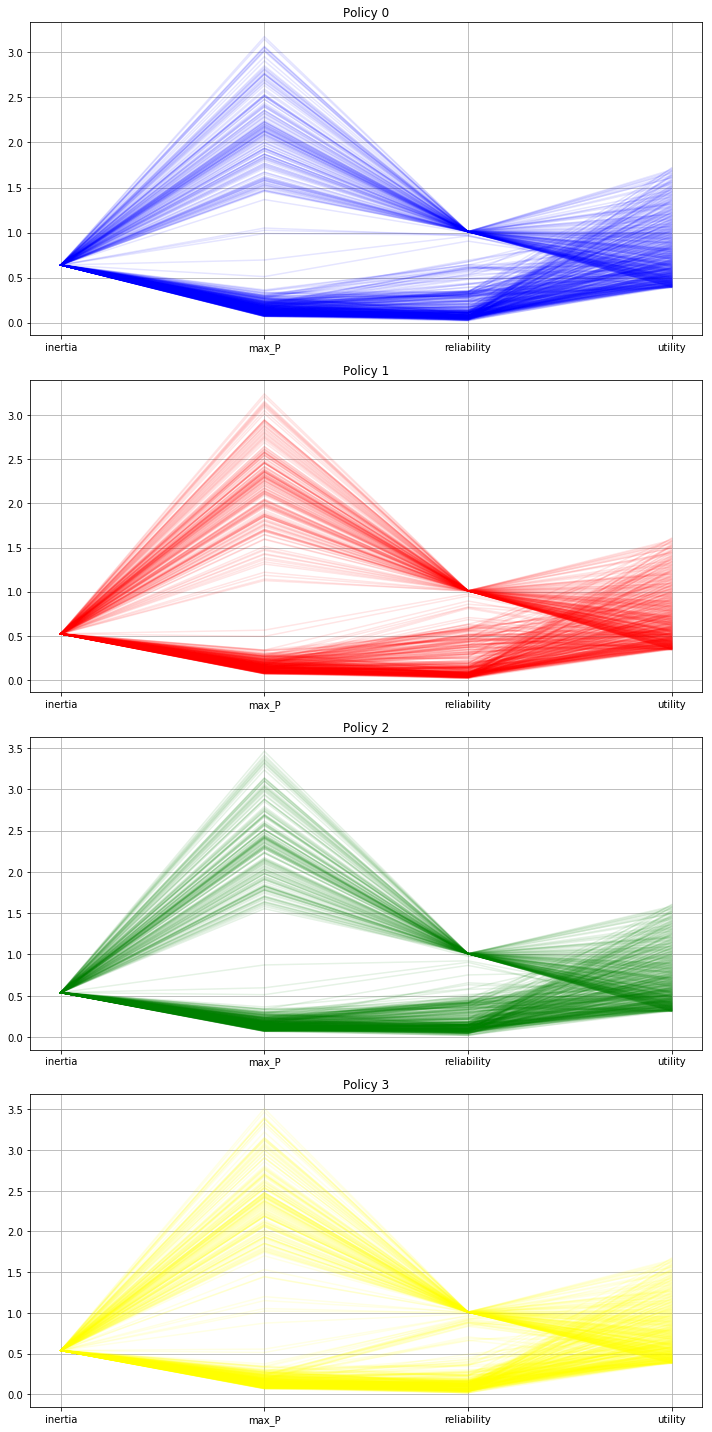

In [78]:
df = robustness(results, mean=False)
outcomes = df.columns
colors = ["blue", "red", "green", "yellow"]

fig, axes = plt.subplots(figsize = (10,20), nrows = 4)
for i in df.index.unique():
    ax = axes[i]
    df_policy = df.loc[i]
    for row in df_policy.reset_index().index:
        df_policy.iloc[row].plot(ax = ax, color = colors[i], alpha = 0.1)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(df.columns)
    ax.set_title("Policy %s"%i)
    ax.grid()
fig.tight_layout()

## Searching for candidate solutions

See the MORDM assignment for setting up platypus.

Set up the robust optimization problem using the robustness functions you have specified. Assume that you will need 50 scenarios for estimating the robustness. Use $\epsilon$-progress to track convergence. Solve the optimization problem. As $\epsilon$ values, you can assume 0.05 for each of the four robustness metrics.

*note: this optimization problem is computationally very expensive. Develop and test your code using a sequential evaluator, a low number of function evaluations (e.g., 200), and a low number of scenarios (e.g., 5). Once everything seems to be working replace the sequential evaluator with an multiprocessing or ipyparallel evaluator, and increase the number of nfe and scenarios*.


**Plot your $\epsilon$-progress to evaluate convergergence, and visualize the trade-offs using parallel coordinate plots**

**What does this plot tell us about the tradeoffs and conflicting objectives?**

## Step 3: Re-evaluate candidate solutions under uncertainty

We have used only 50 scenarios for the optimization. Take the results and re-evaluate them over a larger set (assume 1000 scenarios). How different are your results? What does this imply for the assumption of 50 scenarios during robust optimization.

*hint: use the to_dict method on a dataframe, next generate Policy objects in a list expression by iterating over the dicts returned by the to_dict method*

## Comparison
If you have time, import your solutions found for MORDM and re-evaluate them over the same set of scnearios as used for re-evaluating the MORO results. Compare the robustness of MORDM and MORO, what do you observe?